In [3]:
#import matplotlib.pyplot as plt
import random
import urllib

# Preliminaries

Download a large enough body of text, convert it to uppercase, and keep only latin letters

In [4]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [5]:
def clean(s):
    return "".join( [ x for x in s.upper() if 'A' <= x <= 'Z'] )

In [6]:
text = urllib.request.urlopen("https://gutenberg.net.au/ebooks02/0200051.txt").read().decode("utf-8")

In [7]:
text = clean(text)

# Compute the (empirical) distribution of the letters and plot it

In [38]:
def compute_freqs(s):
    freq = {c : 0 for c in alphabet}
    for c in s:
        freq[c] += 1
    return freq

In [39]:
english_freqs = compute_freqs(text)

In [40]:
def plot_frequencies(freq):
    num_chars = sum(freq.values())
    plt.bar(freq.keys(), [x/num_chars for x in freq.values()] )

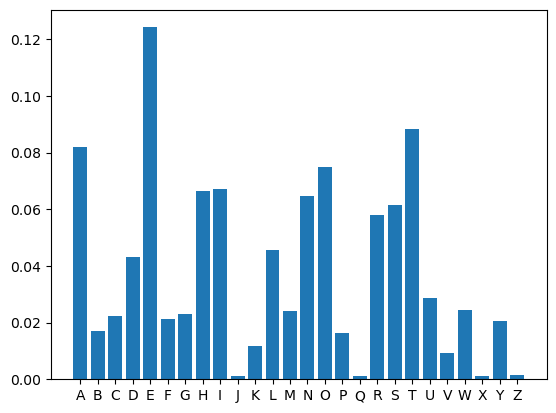

In [53]:
plot_frequencies(english_freqs)

# Shift ciphers

In [42]:
def shift(a, s):
    return chr( ((ord(a) - ord('A')) + s)%26   + ord('A'))

In [43]:
def shift_enc(m, s):
    c = ""
    for x in m.upper():
        c += shift(x, s)
    return c

In [44]:
def shift_dec(c, s):
    m = ""
    for x in c.upper():
        m += shift(x, -s)
    return m

In [45]:
shift_enc("EXAMPLE", 5)

'JCFRUQJ'

In [46]:
shift_dec('JCFRUQJ', 5)

'EXAMPLE'

## Encrypt a challenge plaintext with a random key

In [10]:
with open("challenge1.txt", "r") as f:
    challenge_m = clean(f.read())

In [48]:
secret_k = random.randint(0, 25)

In [49]:
c = shift_enc(challenge_m, secret_k)

## Let's break the shift cipher

In [50]:
freq_c = compute_freqs(c)

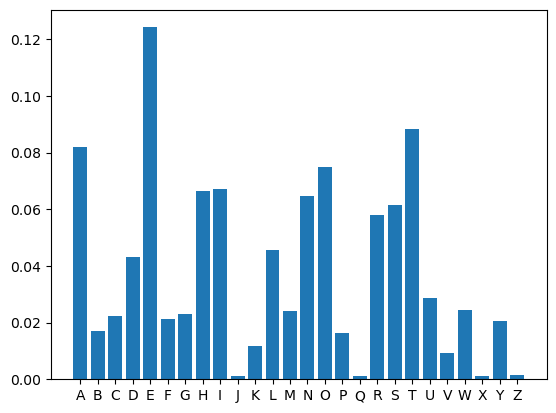

In [54]:
plot_frequencies(english_freqs)

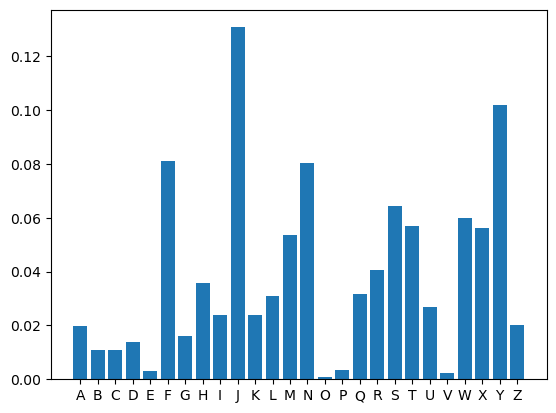

In [56]:
plot_frequencies(freq_c)

From the above figures we can already guess the shift.
We would still like to break the cipher without manually inspecting the plots, so we use the method described in the lectures

In [57]:
def compute_pq(p, q, shift):
    sum_p = sum( [y for (x,y) in p.items() ]  )
    sum_q = sum( [y for (x,y) in q.items() ]  )
    
    s = 0
    for i in range(26):
        s += (p[ chr(i + ord('A')) ]/sum_p) *  (q[ chr( ord('A') +  (i + shift)%26 ) ] /sum_q )
    return s

In [59]:
compute_pq(english_freqs, english_freqs, 0)

0.06449758436144698

In [64]:
def break_ss(c):
    best_score = 2
    best_shift = None
    expected = compute_pq(english_freqs, english_freqs, 0)
    freq_c = compute_freqs(c)
    for s in range(26):
        score = abs(compute_pq(english_freqs, freq_c, s) - expected)
        if score < best_score:
            best_score = score
            best_shift = s

    return best_shift, best_score, shift_dec(c, best_shift)

In [65]:
break_ss(c)

(5,
 0.0007123734376370677,
 'FROMWIKIPEDIATHEFREEENCYCLOPEDIAFORTHETHEOREMABOUTINFINITEGRAPHSSEEKNIGSLEMMAFOROTHERUSESSEEKNIGSTHEOREMDISAMBIGUATIONANEXAMPLEOFABIPARTITEGRAPHWITHAMAXIMUMMATCHINGBLUEANDMINIMUMVERTEXCOVERREDBOTHOFSIZESIXINTHEMATHEMATICALAREAOFGRAPHTHEORYKNIGSTHEOREMPROVEDBYDNESKNIGDESCRIBESANEQUIVALENCEBETWEENTHEMAXIMUMMATCHINGPROBLEMANDTHEMINIMUMVERTEXCOVERPROBLEMINBIPARTITEGRAPHSITWASDISCOVEREDINDEPENDENTLYALSOINBYJENEGERVRYINTHEMOREGENERALCASEOFWEIGHTEDGRAPHSSETTINGAVERTEXCOVERINAGRAPHISASETOFVERTICESTHATINCLUDESATLEASTONEENDPOINTOFEVERYEDGEANDAVERTEXCOVERISMINIMUMIFNOOTHERVERTEXCOVERHASFEWERVERTICESAMATCHINGINAGRAPHISASETOFEDGESNOTWOOFWHICHSHAREANENDPOINTANDAMATCHINGISMAXIMUMIFNOOTHERMATCHINGHASMOREEDGESITISOBVIOUSFROMTHEDEFINITIONTHATANYVERTEXCOVERSETMUSTBEATLEASTASLARGEASANYMATCHINGSETSINCEFOREVERYEDGEINTHEMATCHINGATLEASTONEVERTEXISNEEDEDINTHECOVERINPARTICULARTHEMINIMUMVERTEXCOVERSETISATLEASTASLARGEASTHEMAXIMUMMATCHINGSETKNIGSTHEOREMSTATESTHATINANYBIPARTITEGRAPHTHE

In [66]:
guess_k, _, guess_m = break_ss(c)

In [67]:
guess_k == secret_k

True

In [68]:
guess_m == challenge_m

True

# Vigenère ciphers

In [70]:
def vigenere_enc(m, k):
    shifts = [ ord(x)-ord('A')  for x in k ]
    
    c = ""
    for i in range(len(m)):
        c += chr( (ord( m[i] ) - ord('A') + shifts[i % len(k)])%26 + ord('A'))
    
    return c

In [71]:
def vigenere_dec(c, k):
    shifts = [ ord(x)-ord('A')  for x in k ]

    m=""
    for i in range(len(c)):
        m += chr( (ord( c[i] ) - ord('A') - shifts[i % len(k)])%26 + ord('A'))

    return m

In [72]:
vigenere_enc("TESTING", "AB")

'TFSUIOG'

In [73]:
vigenere_dec("TFSUIOG", "AB")

'TESTING'

## Encrypt a challenge plaintext with a random key

In [74]:
secret_k_len = random.randint(3, 20)

In [75]:
secret_k = "".join([ chr( ord('A') + random.randint(0, 25)) for i in range(secret_k_len) ])

In [76]:
with open("challenge2.txt", "r") as f:
    challenge_m = clean(f.read())

In [77]:
c = vigenere_enc(challenge_m, secret_k)

## Recover the key length using the index of coincidence method

In [79]:
def index_of_coincidence(c, ell):
    c_ell = c[0::ell]
    freqs_c_ell = compute_freqs(c_ell)
        
    ioc = 0
    for x in alphabet:
        ioc += (freqs_c_ell[ x ]/ len(c_ell) )**2
    
    return ioc

In [80]:
iocs = [ index_of_coincidence(c, s) for s in range(1, 20) ]

In [81]:
for i in range(1,20):
    print(i, iocs[i-1])

1 0.04126356948822383
2 0.044047964044113666
3 0.04665528869440061
4 0.04951024429432567
5 0.04119570532040927
6 0.05103127516306814
7 0.04169954073200509
8 0.048123349500202195
9 0.04803840877914952
10 0.04621585462920626
11 0.043743985585880725
12 0.07368998628257889
13 0.04318110326288999
14 0.04287885457067163
15 0.04936366407559823
16 0.049233898891966756
17 0.04491662183969877
18 0.057037037037037046
19 0.04339599609375


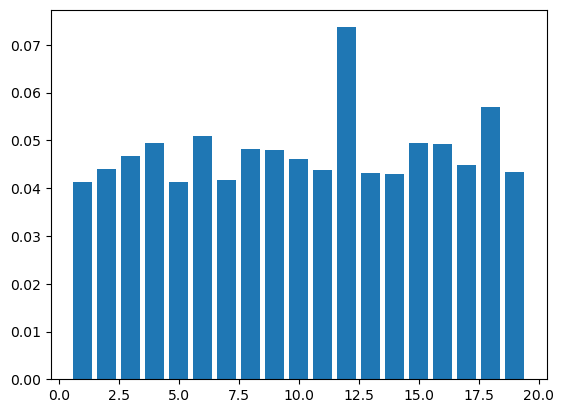

In [82]:
plt.bar( range(1, 20), iocs)
plt.show()

In [83]:
guess_len = 12

## Decompose the ciphertext into many sub-ciphertext with the same shift, and break them

In [84]:
sub_c = [ c[i::guess_len] for i in range(guess_len)  ]

In [85]:
sub_m = [  break_ss(sub_c[i])[2] for i in range(guess_len) ]

In [86]:
shifts_m = [  break_ss(sub_c[i])[0] for i in range(guess_len) ]

## Recover the plaintext and the key

In [87]:
guess_m = ""
for i in range(len(c)):
    guess_m += sub_m[i%guess_len][i//guess_len]

In [88]:
guess_m

'SOMETOILETROLLHOLDERSORDISPENSERSALLOWTHETOILETPAPERTOHANGINFRONTOFOVERORBEHINDUNDERTHEROLLWHENITISPLACEDPARALLELTOTHEWALLTHISDIVIDESOPINIONSABOUTWHICHORIENTATIONISBETTERARGUMENTSRANGEFROMAESTHETICSHOSPITALITYEASEOFACCESSANDCLEANLINESSTOPAPERCONSERVATIONEASEOFDETACHINGSHEETSANDCOMPATIBILITYWITHPETSTHEUSADVICECOLUMNASKANNLANDERSREPORTEDTHATTHESUBJECTWASTHEMOSTCONTROVERSIALISSUEINTHECOLUMNSHISTORYANDATLETTERSINPROVOKEDTHEHIGHESTNUMBEROFRESPONSESTHECASESTUDYOFTOILETPAPERORIENTATIONHASBEENUSEDASATEACHINGTOOLININSTRUCTINGSOCIOLOGYSTUDENTSINTHEPRACTICEOFSOCIALCONSTRUCTIONISMARGUMENTSTWOPAPERHOLDERSEACHWITHDIFFERENTORIENTATIONTHEMAINREASONSGIVENBYPEOPLETOEXPLAINWHYTHEYHANGTHEIRTOILETPAPERAGIVENWAYAREEASEOFGRABBINGANDHABITTHEOVERPOSITIONREDUCESTHERISKOFACCIDENTALLYBRUSHINGTHEWALLORCABINETWITHONESKNUCKLESPOTENTIALLYTRANSFERRINGGRIMEANDGERMSMAKESITEASIERTOVISUALLYLOCATEANDTOGRASPTHELOOSEENDGIVESTHEOPTIONTOFOLDOVERTHELASTSHEETTOSHOWTHATTHEROOMHASBEENCLEANEDANDISGENERALLYTHEINTENDEDDIRECTIONOFVIE

In [89]:
guess_k = "".join([ chr(ord('A') + shifts_m[i]) for i in range(guess_len)])

In [90]:
guess_k

'PZALDDXUWKMA'

In [91]:
guess_len == secret_k_len

True

In [92]:
guess_k == secret_k

True